<a href="https://colab.research.google.com/github/drizzletechnova/Coursera-data-science-/blob/main/Copy_of_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
def format_with_commas(x):
    return "{:,.0f}".format(x)
#pd.options.display.float_format = format_with_commas
pd.set_option('display.float_format',format_with_commas)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [82]:
import requests

url = 'https://data.montgomerycountymd.gov/api/views/v76h-r7br/rows.csv?accessType=DOWNLOAD'
response = requests.get(url)

if response.status_code == 200:
    with open('retail.csv', 'wb') as file:
        file.write(response.content)
    print('File downloaded successfully')
else:
    print('Failed to download file')

File downloaded successfully


In [128]:

data = pd.read_csv("retail.csv")
data.head()

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.00,0.00,2.00
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.00,1.00,4.00
2,2020,1,RELIABLE CHURCHILL LLLP,1001,S SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,0.00,0.00,1.00
3,2020,1,LANTERNA DISTRIBUTORS INC,100145,SCHLINK HAUS KABINETT - 750ML,WINE,0.00,0.00,1.00
4,2020,1,DIONYSOS IMPORTS INC,100293,SANTORINI GAVALA WHITE - 750ML,WINE,0.82,0.00,0.00


# Data description

In [78]:

features = {
    "Feature": [
        "YEAR", "MONTH", "SUPPLIER", "ITEM CODE", "ITEM DESCRIPTION",
        "ITEM TYPE", "RETAIL SALES", "RETAIL TRANSFERS", "WAREHOUSE SALES"
    ],
    "Description": [
        "Calendar Year", "Month", "Supplier Name", "Item code",
        "Item Description", "Item Type", "Cases of product sold from DLC dispensaries",
        "Cases of product transferred to DLC dispensaries", "Cases of product sold to MC licensees"
    ],
    "Data Type": [
        "Number", "Number", "Text", "Text", "Text", "Text", "Number", "Number", "Number"
    ]
}

# Create a DataFrame
df = pd.DataFrame(features)

df

,Feature,Description,Data Type
0,YEAR,Calendar Year,Number
1,MONTH,Month,Number
2,SUPPLIER,Supplier Name,Text
3,ITEM CODE,Item code,Text
4,ITEM DESCRIPTION,Item Description,Text
5,ITEM TYPE,Item Type,Text
6,RETAIL SALES,Cases of product sold from DLC dispensaries,Number
7,RETAIL TRANSFERS,Cases of product transferred to DLC dispensaries,Number
8,WAREHOUSE SALES,Cases of product sold to MC licensees,Number


In [147]:
data.columns = data.columns.str.replace(' ', '_')

In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307645 entries, 0 to 307644
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   YEAR              307645 non-null  int64  
 1   MONTH             307645 non-null  int64  
 2   SUPPLIER          307478 non-null  object 
 3   ITEM_CODE         307645 non-null  object 
 4   ITEM_DESCRIPTION  307645 non-null  object 
 5   ITEM_TYPE         307644 non-null  object 
 6   RETAIL_SALES      307642 non-null  float64
 7   RETAIL_TRANSFERS  307645 non-null  float64
 8   WAREHOUSE_SALES   307645 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 21.1+ MB


In [89]:
data.shape

(307645, 9)

In [146]:
data.isnull().sum()

,0
YEAR,0
MONTH,0
SUPPLIER,167
ITEM CODE,0
ITEM DESCRIPTION,0
ITEM TYPE,1
RETAIL SALES,3
RETAIL TRANSFERS,0
WAREHOUSE SALES,0


In [149]:
data["TOTAL_SALES"] = data["RETAIL_SALES"] + data["WAREHOUSE_SALES"]

In [154]:
data.drop(columns = ["ITEM_CODE"], inplace= True)

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307645 entries, 0 to 307644
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   YEAR              307645 non-null  int64  
 1   MONTH             307645 non-null  int64  
 2   SUPPLIER          307478 non-null  object 
 3   ITEM_DESCRIPTION  307645 non-null  object 
 4   ITEM_TYPE         307644 non-null  object 
 5   RETAIL_SALES      307642 non-null  float64
 6   RETAIL_TRANSFERS  307645 non-null  float64
 7   WAREHOUSE_SALES   307645 non-null  float64
 8   TOTAL_SALES       307642 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 21.1+ MB


In [156]:

numeric_cols = data.select_dtypes(include=['float64', 'int64'])
non_numeric_cols = data.select_dtypes(exclude=['float64', 'int64'])

In [157]:
print('number of numeric columns' ,numeric_cols.shape[1])
print('number of categorical columns' ,non_numeric_cols.shape[1])

number of numeric columns 6
number of categorical columns 3


In [158]:
numeric_cols.describe()

,YEAR,MONTH,RETAIL_SALES,RETAIL_TRANSFERS,WAREHOUSE_SALES,TOTAL_SALES
count,307645.00,307645.00,307642.00,307645.00,307645.00,307642.00
mean,2018.44,6.42,7.02,6.94,25.29,32.32
std,1.08,3.46,30.99,30.24,249.92,266.49
min,2017.00,1.00,-6.49,-38.49,-7800.00,-7800.00
25%,2017.00,3.00,0.00,0.00,0.00,1.00
50%,2019.00,7.00,0.32,0.00,1.00,2.68
75%,2019.00,9.00,3.27,3.00,5.00,10.50
max,2020.00,12.00,2739.00,1990.83,18317.00,19491.00


In [159]:
non_numeric_cols.describe()

,SUPPLIER,ITEM_DESCRIPTION,ITEM_TYPE
count,307478,307645,307644
unique,396,34822,8
top,REPUBLIC NATIONAL DISTRIBUTING CO,BURGANS ALBARINO - 750ML,WINE
freq,20995,44,187640


In [102]:
data["ITEM_TYPE"].value_counts()

,count
ITEM_TYPE,
WINE,187640
LIQUOR,64910
BEER,42413
KEGS,10146
NON-ALCOHOL,1908
STR_SUPPLIES,405
REF,127
DUNNAGE,95


In [103]:
def plot_dist(df,variable,target):
    df = df.sample(1000)
    plt.tight_layout()
    plt.figure(figsize=(20,4))
    # histogram
    plt.subplot(1,3,1)
    # plt.xticks(rotation=90)
    sns.histplot(x = np.log(df[variable]),bins=30,data=df)
    plt.title('histogram')
    plt.yticks(rotation=90)
    #scatter plot
    plt.subplot(1,3,2)
    sns.scatterplot(x= variable,y= target,data=df)
    plt.title('scatter')
    #regplot
    plt.subplot(1,3,3)
    sns.regplot(y= target,x=variable,data=df)
    plt.title('regplot')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr

<Figure size 640x480 with 0 Axes>

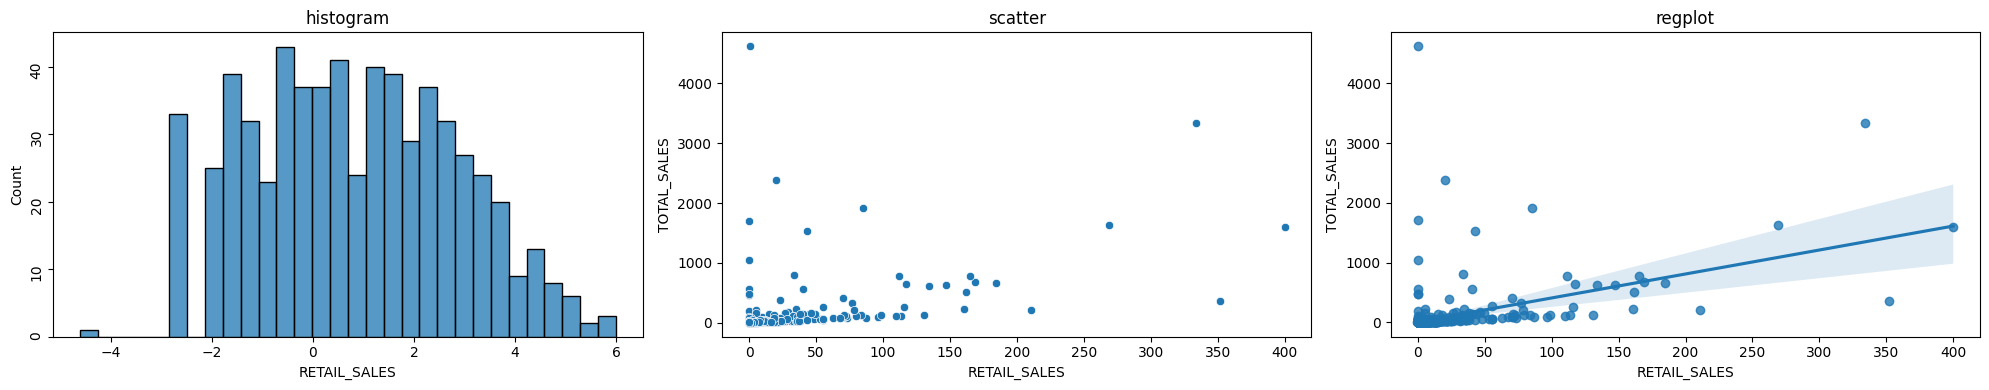

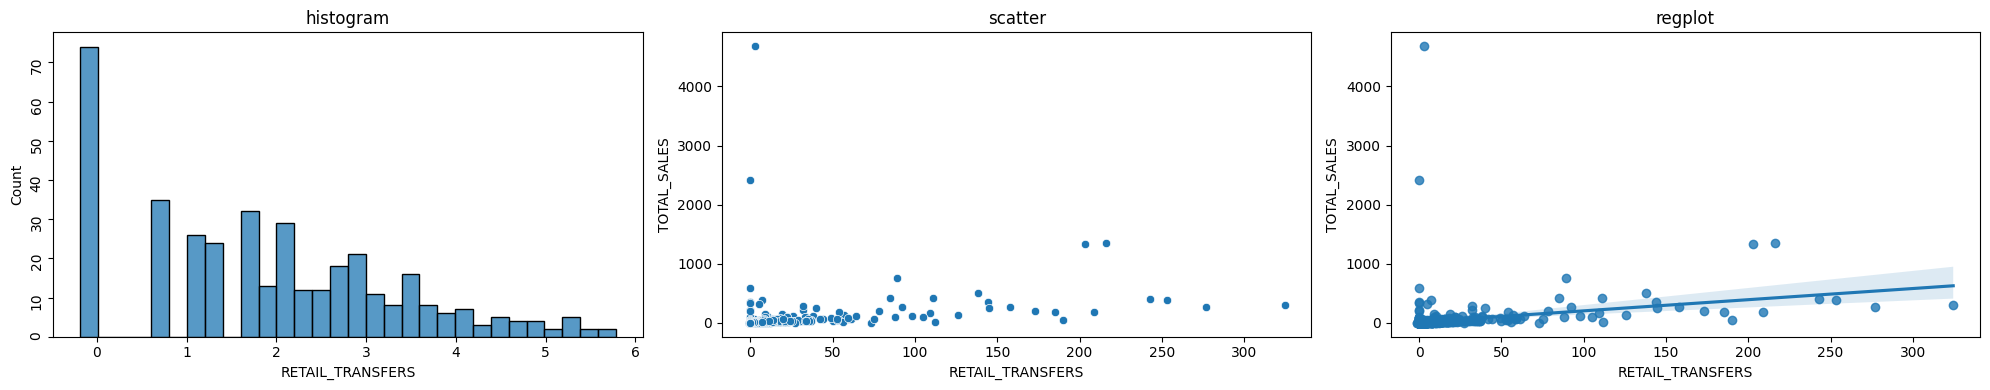

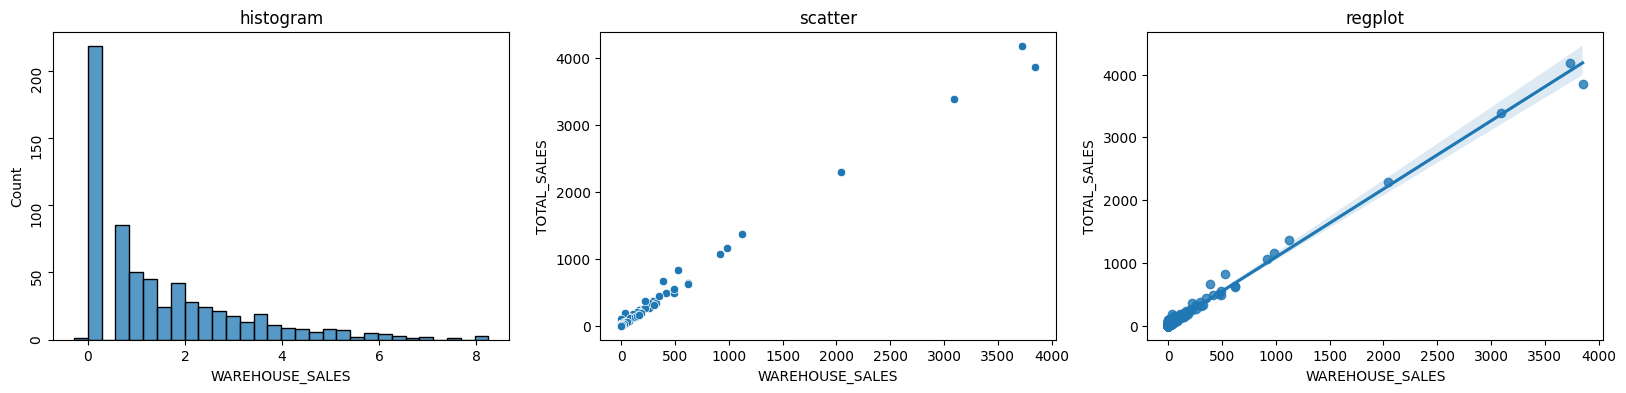

In [104]:
# List of columns to exclude
exclude_columns = ['MONTH', 'YEAR', 'TOTAL_SALES']

# Exclude specified columns from the numeric_cols DataFrame
Features = numeric_cols.drop(columns=exclude_columns).columns

# Loop through each remaining feature and plot the distribution
for feature in Features:
    plot_dist(numeric_cols, feature, "TOTAL_SALES")

In [ ]:
def plot_time(df,variable,target):
    df = df.sample(10000)
    plt.show()
    plt.tight_layout()
    plt.figure(figsize=(20,5))
    # histogram
    plt.subplot(1,2,1)
    sns.histplot(x = variable,bins=10,data=df)
    plt.xticks(df[variable].astype(int).unique(), rotation=90)
    plt.title('histogram')
    #barplot
    plt.subplot(1,2,2)
    sns.barplot(x= variable,y=target,data=df)
    plt.title('barplot')

<Figure size 640x480 with 0 Axes>

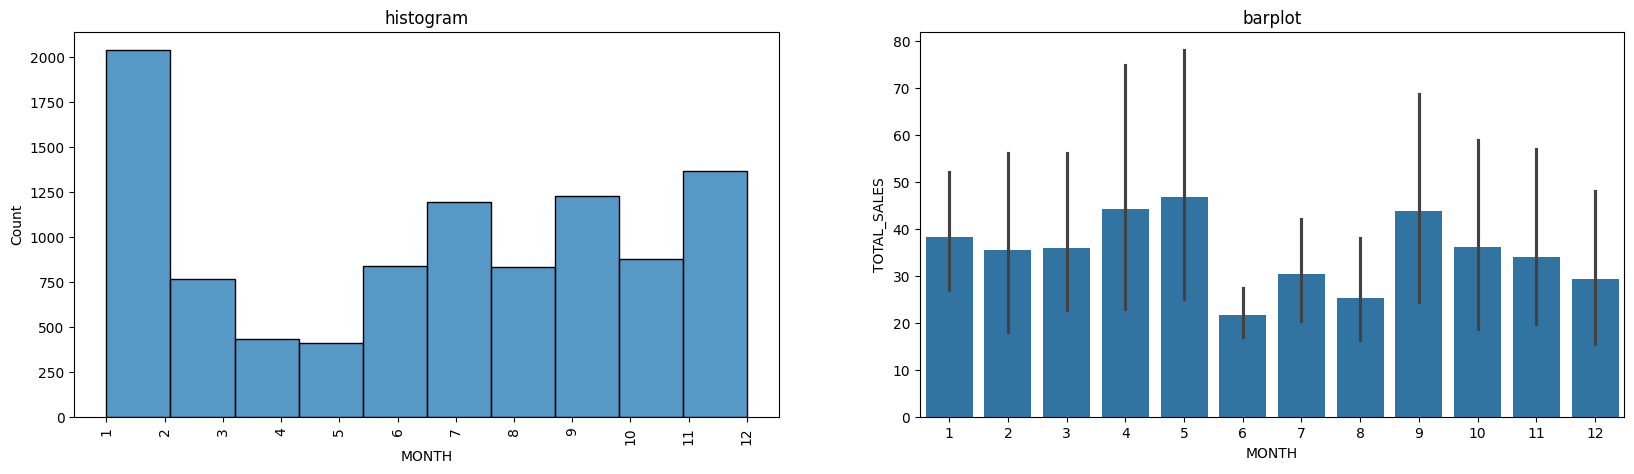

<Figure size 640x480 with 0 Axes>

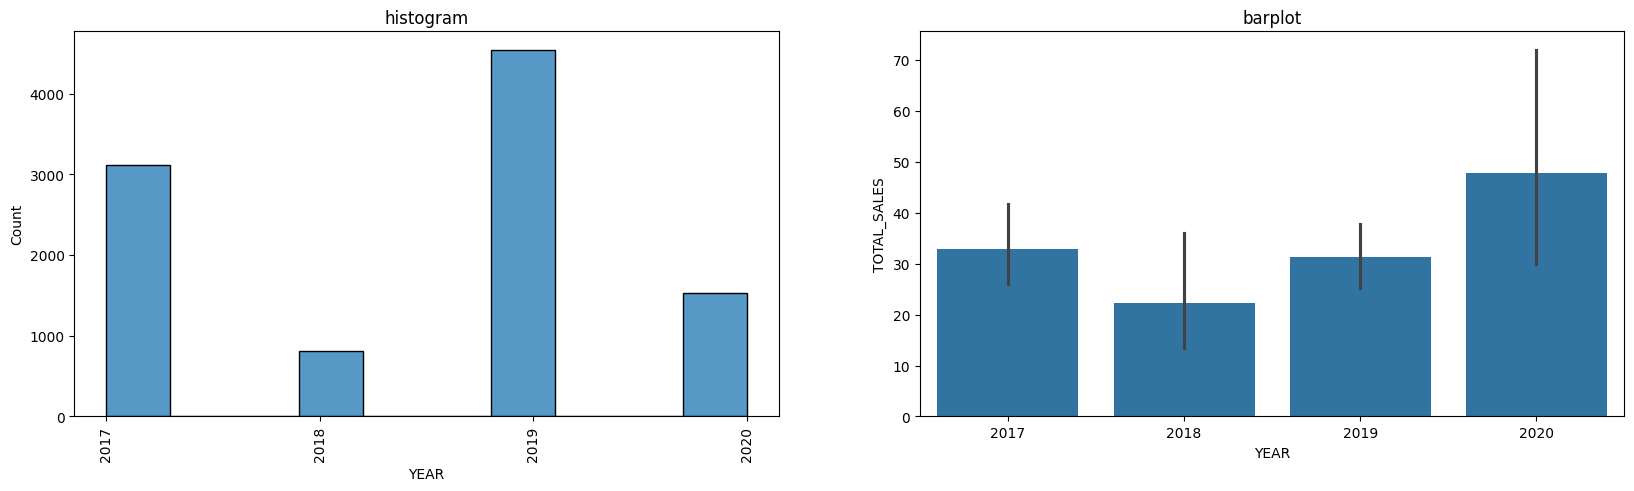

In [105]:
Features = ['MONTH','YEAR']
for feature in Features:
    plot_time(numeric_cols, feature, "TOTAL_SALES")

In [ ]:
def plot_category(df, feature, target):
    plt.figure(figsize=(20,4))
    df = df.sample(1000)
    plt.subplot(1,3,1)
    #boxplot
    sns.boxplot(data=df, x=feature, y=target)
    plt.title('boxplot of ' + feature)
    plt.xticks(rotation=90)
    plt.subplot(1,3,2)
    #countplot
    sns.countplot(data = df, x = feature)
    plt.xticks(rotation=90)
    plt.title('countplot of ' + feature)
    plt.subplot(1,3,3)
    plt.xticks(rotation=90)
    #stripplot
    sns.stripplot(data=df, x=feature, y=target)
    plt.title('Strip plot of ' + 'price' + ' by ' + feature)
    plt.show()

**utility functions**

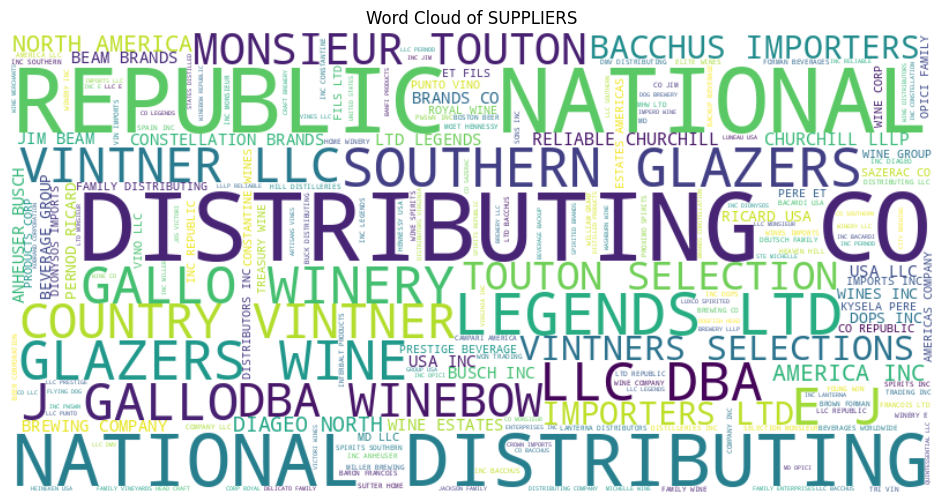

In [107]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming data['SUPPLIER'] contains the supplier descriptions
# Convert all items in the list to strings to avoid TypeError
text = ' '.join(map(str, data['SUPPLIER']))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of SUPPLIERS')
plt.show()

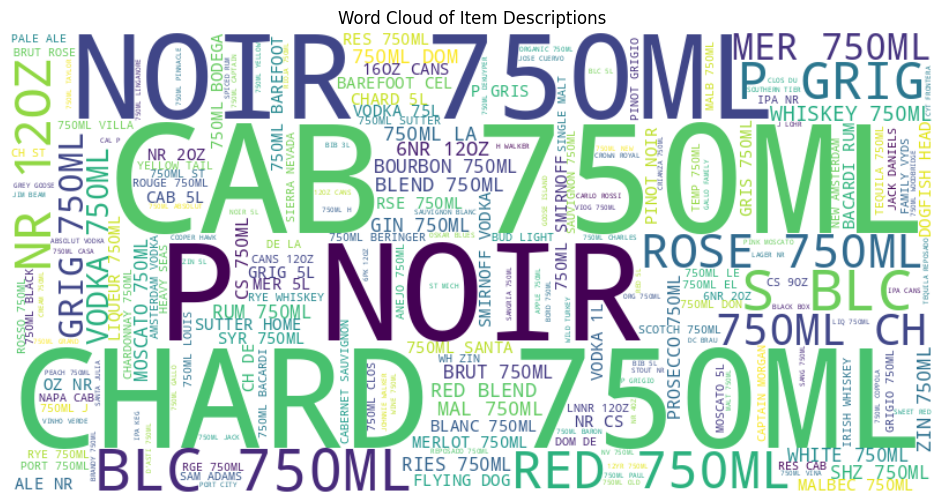

In [108]:
from wordcloud import WordCloud

text = ' '.join(data['ITEM_DESCRIPTION'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Item Descriptions')
plt.show()

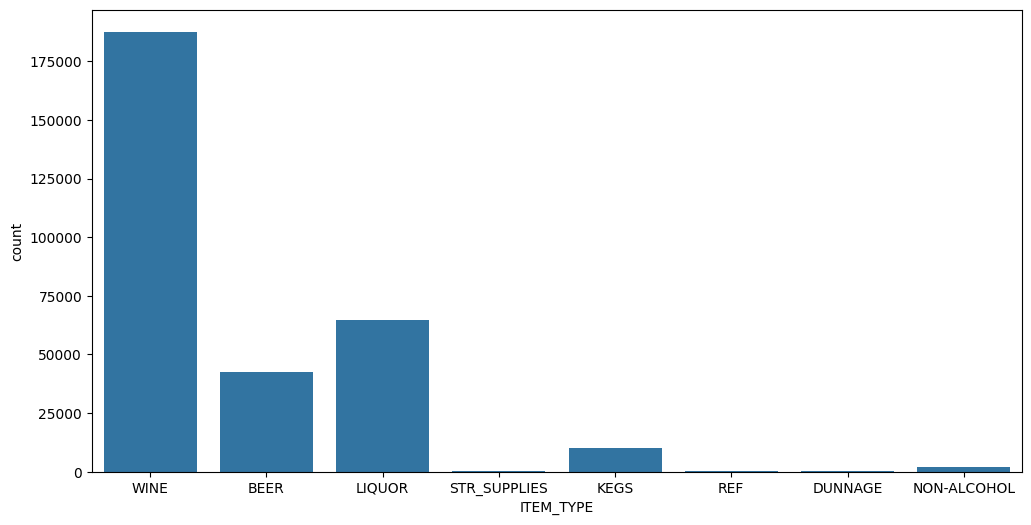

<Figure size 640x480 with 0 Axes>

In [126]:
plt.figure(figsize=(12,6))
sns.countplot (x = data["ITEM_TYPE"])
plt.show()
plt.tight_layout()

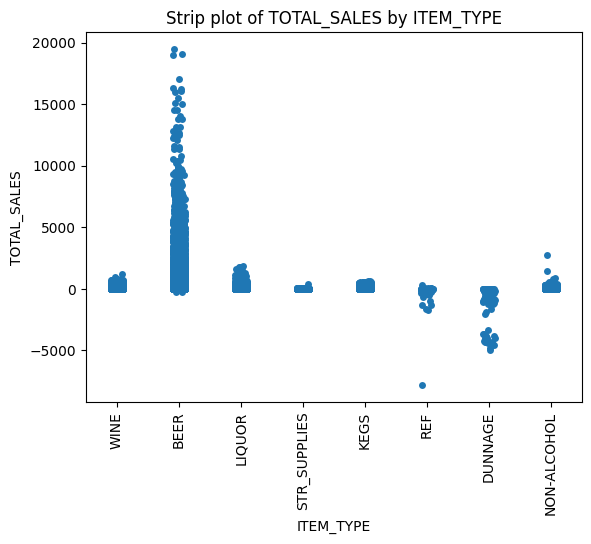

In [116]:
sns.stripplot(data=df, x=data["ITEM_TYPE"], y=data["TOTAL_SALES"])
plt.title('Strip plot of ' + 'TOTAL_SALES' + ' by ' + 'ITEM_TYPE')
plt.xticks(rotation=90)
plt.show()

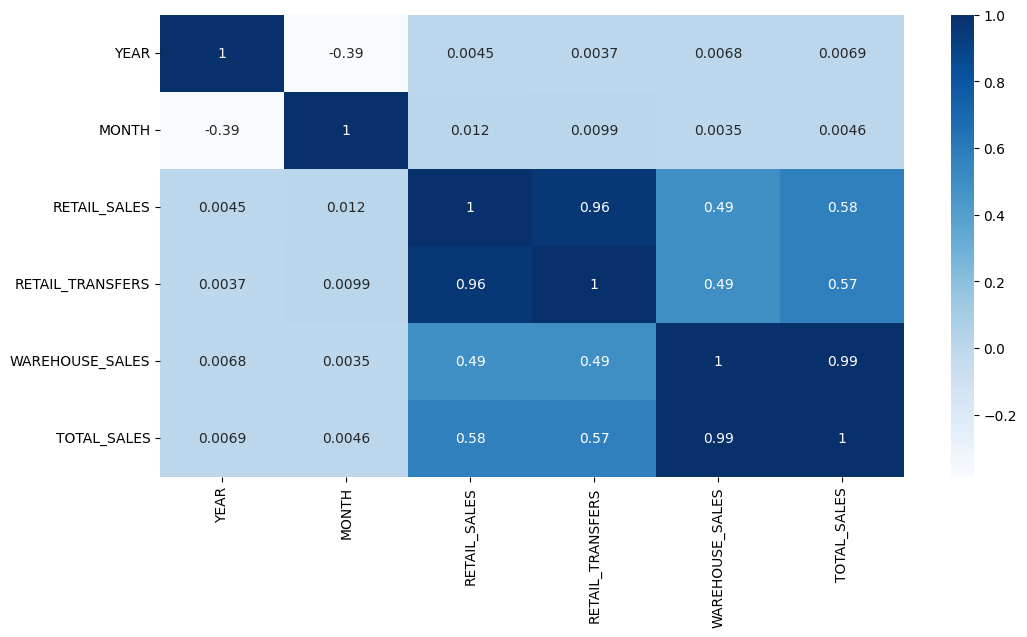

In [117]:

plt.figure(figsize=(12,6))
sns.heatmap(numeric_cols.corr(),annot=True, cmap='Blues')
plt.show()

In [ ]:
categorical = pd.crosstab(non_numeric_cols['ITEM_DESCRIPTION'],non_numeric_cols['ITEM_TYPE'],non_numeric_cols['SUPPLIER'],aggfunc='count',margins=True)

# Create the heatmap
# sns.heatmap(categorical, annot=True, cmap="Blues")

# Data Preprocessing

In [152]:
ss = StandardScaler()
ohe = OneHotEncoder()
LR = LinearRegression()
ridge = Ridge()

TypeError: 'Ridge' object is not callable

In [119]:
numeric_preprocess = Pipeline(steps = [
("scale",ss),
("impute",SimpleImputer())
])
numeric_preprocess

Pipeline(steps=[('scale', StandardScaler()), ('impute', SimpleImputer())])

In [129]:
categorical_preprocess = Pipeline(steps = [
("encoder",ohe),
("impute",SimpleImputer(strategy = "most_frequent"))

])
categorical_preprocess

Pipeline(steps=[('encoder', OneHotEncoder()),
                ('impute', SimpleImputer(strategy='most_frequent'))])

In [130]:
preprocessor = ColumnTransformer(transformers = [
("numerical",numeric_preprocess, numeric_cols),
("categorical",categorical_preprocess,non_numeric_cols)
])
preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('scale', StandardScaler()),
                                                 ('impute', SimpleImputer())]),
                                         YEAR  MONTH  RETAIL_SALES  RETAIL_TRANSFERS  WAREHOUSE_SALES  \
0       2020      1          0.00              0.00             2.00   
1       2020      1          0.00              1.00             4.00   
2       2020      1          0.00              0.00             1.00   
3       2020      1          0.00              0.00             1.00   
4       2020      1          0.82              0.00             0.00   
...      ...    ...           ...               ...              ...   
307640  2020      9          0.00              0.00            54.00   
307641  2020      9          1.50              1.00             8.00   
307642  2020      9          0.00              0.00            22.00   
3...
                           ITEM_DESCRIPTION ITEM_TYPE  
0                       BOOTLEG RED - 750ML      WINE  
1                 MOMENT DE PLAISIR - 750ML      WINE  
2       S SMITH ORGANIC PEAR CIDER - 18.7OZ      BEER  
3             SCHLINK HAUS KABINETT - 750ML      WINE  
4            SANTORINI GAVALA WHITE - 750ML      WINE  
...                                     ...       ...  
307640           SAM ADAMS OCTOBERFEST 1/6K      KEGS  
307641            HARAR BEER 4/6NR - 11.2OZ      BEER  
307642                 DOS EQUIS LAGER 1/2K      KEGS  
307643          LINDEMANS KRIEK NR - 25.4OZ      BEER  
307644        ARIS GREEK LAGER 4/6NR - 11OZ      BEER  

[307645 rows x 3 columns])])

In [132]:
pipeline = Pipeline(steps = [
("preprocessor", preprocessor),
("model",LR),
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler()),
                                                                  ('impute',
                                                                   SimpleImputer())]),
                                                          YEAR  MONTH  RETAIL_SALES  RETAIL_TRANSFERS  WAREHOUSE_SALES  \
0       2020      1          0.00              0.00             2.00   
1       2020      1          0.00              1.00             4.00   
2       2020      1          0.00              0.00             1.00   
3       2020      1          0.00              0.00             1.00   
4       2020      1          0.82              0.00             0.00   
...      ...    ...           ...               ...              ...   
307640  2020      9          0.00              0.00            54.00   
307641  2020      9          1.50              1...
0                       BOOTLEG RED - 750ML      WINE  
1                 MOMENT DE PLAISIR - 750ML      WINE  
2       S SMITH ORGANIC PEAR CIDER - 18.7OZ      BEER  
3             SCHLINK HAUS KABINETT - 750ML      WINE  
4            SANTORINI GAVALA WHITE - 750ML      WINE  
...                                     ...       ...  
307640           SAM ADAMS OCTOBERFEST 1/6K      KEGS  
307641            HARAR BEER 4/6NR - 11.2OZ      BEER  
307642                 DOS EQUIS LAGER 1/2K      KEGS  
307643          LINDEMANS KRIEK NR - 25.4OZ      BEER  
307644        ARIS GREEK LAGER 4/6NR - 11OZ      BEER  

[307645 rows x 3 columns])])),
                ('model', LinearRegression())])

In [160]:
data

,YEAR,MONTH,SUPPLIER,ITEM_DESCRIPTION,ITEM_TYPE,RETAIL_SALES,RETAIL_TRANSFERS,WAREHOUSE_SALES,TOTAL_SALES
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,BOOTLEG RED - 750ML,WINE,0.00,0.00,2.00,2.00
1,2020,1,PWSWN INC,MOMENT DE PLAISIR - 750ML,WINE,0.00,1.00,4.00,4.00
2,2020,1,RELIABLE CHURCHILL LLLP,S SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,0.00,0.00,1.00,1.00
3,2020,1,LANTERNA DISTRIBUTORS INC,SCHLINK HAUS KABINETT - 750ML,WINE,0.00,0.00,1.00,1.00
4,2020,1,DIONYSOS IMPORTS INC,SANTORINI GAVALA WHITE - 750ML,WINE,0.82,0.00,0.00,0.82
...,...,...,...,...,...,...,...,...,...
307640,2020,9,BOSTON BEER CORPORATION,SAM ADAMS OCTOBERFEST 1/6K,KEGS,0.00,0.00,54.00,54.00
307641,2020,9,GLOBAL OCEAN AND AIR CARGO SERVICES,HARAR BEER 4/6NR - 11.2OZ,BEER,1.50,1.00,8.00,9.50
307642,2020,9,HEINEKEN USA,DOS EQUIS LAGER 1/2K,KEGS,0.00,0.00,22.00,22.00
307643,2020,9,RELIABLE CHURCHILL LLLP,LINDEMANS KRIEK NR - 25.4OZ,BEER,0.00,0.00,4.00,4.00


#Model Building

In [161]:
housing = data.copy()
# sns.pairplot(housing)

In [162]:

X = housing.drop(columns = ["TOTAL_SALES"])
y = housing["TOTAL_SALES"]
X.shape,y.shape

((307645, 8), (307645,))

In [163]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 443)

In [164]:
X_train.shape,X_test.shape

((230733, 8), (76912, 8))

In [165]:
X_train.head(10)

,YEAR,MONTH,SUPPLIER,ITEM_DESCRIPTION,ITEM_TYPE,RETAIL_SALES,RETAIL_TRANSFERS,WAREHOUSE_SALES
249421,2019,8,INTERNATIONAL CELLARS LLC,TALAMONTI TRE SAGGI - 750ML,WINE,0.00,0.00,1.00
229451,2019,6,LEGENDS LTD,FOUNDERS SOLID GOLD 1/2 KEG,KEGS,0.00,0.00,1.00
160736,2019,1,LANTERNA DISTRIBUTORS INC,TENUTA S ANNA P/GRIG - 750ML,WINE,0.00,0.00,30.00
107279,2017,11,WINE BRIDGE IMPORTS INC,2 COPAS MAL/TEMP - 750ML,WINE,0.49,0.00,1.00
222788,2019,6,LEGENDS LTD,LA TRAPPE QUAD 6/4 NR - 11OZ,BEER,0.00,0.00,3.00
28842,2020,3,DIAGEO NORTH AMERICA INC,SMIRNOFF VODKA - 750ML,LIQUOR,146.37,161.00,4.00
108971,2017,11,SOUTHERN GLAZERS WINE AND SPIRITS,CHARLES KRUG NAPA CAB - 750ML,WINE,1.38,2.00,3.00
158503,2019,1,RELIABLE CHURCHILL LLLP,PRAIRIE ORGANIC VODKA - 1L,LIQUOR,0.00,0.00,2.00
18411,2020,7,E & J GALLO WINERY,E&J BRANDY VS - 750ML,LIQUOR,23.66,25.00,0.00
123525,2017,12,KYSELA PERE ET FILS LTD,ALAIN DE LA TREILLE P/NOIR 14 - 750ML,WINE,2.37,0.00,10.00


In [166]:
X_train_pipeline  = pipeline.fit_transform(X_train,y_train)
X_test_pipeline = pipeline.fit(X_test,y_test)

AttributeError: This 'Pipeline' has no attribute 'fit_transform'

In [170]:
#help(pipeline)

In [167]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge

# Sample data
data = {
    'num1': [1.0, 2.0, np.nan, 4.0],
    'num2': [5.0, np.nan, 7.0, 8.0],
    'cat1': ['a', 'b', 'a', 'b'],
    'cat2': ['x', 'y', np.nan, 'y'],
    'target': [1, 2, 3, 4]
}

df = pd.DataFrame(data)
X = df.drop('target', axis=1)
y = df['target']

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the column names for numeric and categorical features
numeric_cols = ['num1', 'num2']
non_numeric_cols = ['cat1', 'cat2']

# Define your preprocessing steps for numerical and categorical columns
ss = StandardScaler()
ohe = OneHotEncoder()
numeric_preprocess = Pipeline(steps=[
    ("impute", SimpleImputer()),  # Impute first
    ("scale", ss)
])
categorical_preprocess = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),  # Impute first
    ("encoder", ohe)
])

# Define the column transformer to apply different preprocessing steps to different columns
preprocessor = ColumnTransformer(transformers=[
    ("numerical", numeric_preprocess, numeric_cols),
    ("categorical", categorical_preprocess, non_numeric_cols)
])

# Define the final pipeline combining preprocessing and modeling
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())  # You can change the model here (e.g., Ridge())
])

# Fit the pipeline to the training data and transform it
pipeline.fit(X_train, y_train)

# Transform the test data using the fitted pipeline (no fitting should be done on test data)
X_train_pipeline = pipeline.transform(X_train)
X_test_pipeline = pipeline.transform(X_test)

print(X_train_pipeline)
print(X_test_pipeline)

AttributeError: This 'Pipeline' has no attribute 'transform'